In [8]:
import os
import pandas as pd
import numpy as np 

import tensorflow

import matplotlib.pylab as plt
import ot
import ot.plot
import cv2

from sklearn.metrics import accuracy_score

In [2]:
import sys
package = os.path.dirname(os.getcwd())
sys.path.append(package)
sys.path.append(package + '/utils')
sys.path

['/anaconda3/envs/venv/lib/python36.zip',
 '/anaconda3/envs/venv/lib/python3.6',
 '/anaconda3/envs/venv/lib/python3.6/lib-dynload',
 '',
 '/Users/kenzaamara/.local/lib/python3.6/site-packages',
 '/anaconda3/envs/venv/lib/python3.6/site-packages',
 '/anaconda3/envs/venv/lib/python3.6/site-packages/IPython/extensions',
 '/Users/kenzaamara/.ipython',
 '/Users/kenzaamara/Documents/ETH Zurich/Master/Master Thesis/code/oneforest',
 '/Users/kenzaamara/Documents/ETH Zurich/Master/Master Thesis/code/oneforest/utils']

In [3]:
import utils 

from utils.citizen_science import *
from utils.extract_features import *

from utils.deepforest_detection import *
from utils.deepforest_evaluation import *

from utils.visualisation import *
from utils.plot_folium import *
from utils.plot_density import *

from utils.mapping import *

Using TensorFlow backend.


In [4]:
def index_nn(X_ground_nn, X_drone_nn):
    
    n = len(X_ground_nn)
    m = len(X_drone_nn)
    X = np.concatenate([X_ground_nn, X_drone_nn])
    
    dists, idxs = nearest_neighbors(X, nbr_neighbors=n+m)

    ground_index = []
    for i in range(n):
        p = 1
        id = X[i,2]
        while(X[idxs[i][p], 2] == id):
            p += 1
        j = idxs[i,p]
        ground_index.append(j-n)
    ground_index = np.array(ground_index, dtype = np.int32)
    return(ground_index)

# Simulate Increasing Random Noise

In [5]:
boxes = pd.read_csv('evaluation/hand_test_example.csv', names = ['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label', 'is_musacea'])

In [6]:
boxes[['x', 'y']] = boxes.apply(lambda x: [get_center(x.xmin,x.xmax), get_center(x.ymin,x.ymax)], axis=1, result_type="expand")

In [10]:
boxes.img_path = 'Flora Pluas RGB_7_3800_7600_7800_11600.png'

### CNN filtering

In [39]:
cnn_model = tensorflow.keras.models.load_model('cnn/cnn_model')
site_name = 'Flora Pluas RGB'
boxes = predict_musacea(boxes, site_name, cnn_model)

TypeError: iteration over a 0-d array

In [15]:
# True is_musacea ('is_musacea_g')

y_true = np.load('cnn/test/labels.npy')
y_true = y_true.astype(int)
boxes['is_musacea_g'] = y_true

In [13]:
boxes = boxes.rename(columns = {"is_musacea": "is_musacea_d"})
boxes.columns

Index(['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label', 'is_musacea_d',
       'x', 'y'],
      dtype='object')

In [14]:
X_d = boxes[['x', 'y']].to_numpy()
X_g = boxes[['x', 'y']].to_numpy()

In [54]:
mus_d = boxes.is_musacea_d.to_numpy()
mus_d = np.vstack(mus_d).reshape(-1)
mus_g = boxes.is_musacea_g.to_numpy()

In [57]:
d_x = boxes.x.max() - boxes.x.min()
d_y = boxes.y.max() - boxes.y.min()
d_x, d_y

(3880.0, 3836.0)

In [66]:
ratios = [1e-4, 1e-3, 0.005, 0.007, 1e-2, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.5, 0.7, 1]
ratios = np.linspace(0.05, 0.15, 20)
r_shift = [0.1, 0.1]

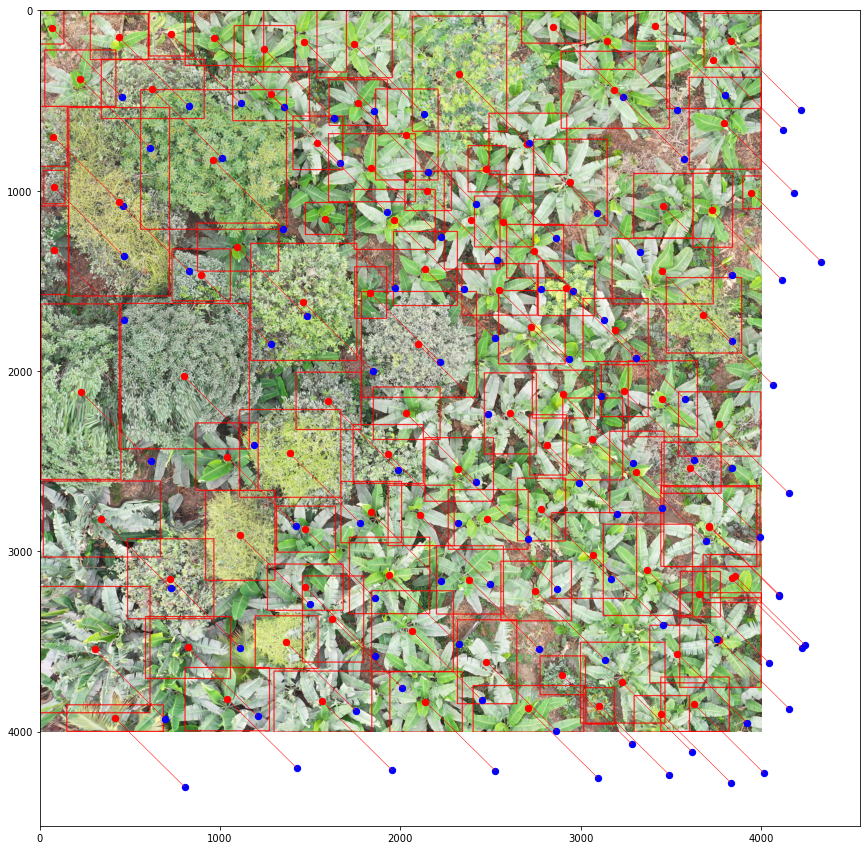

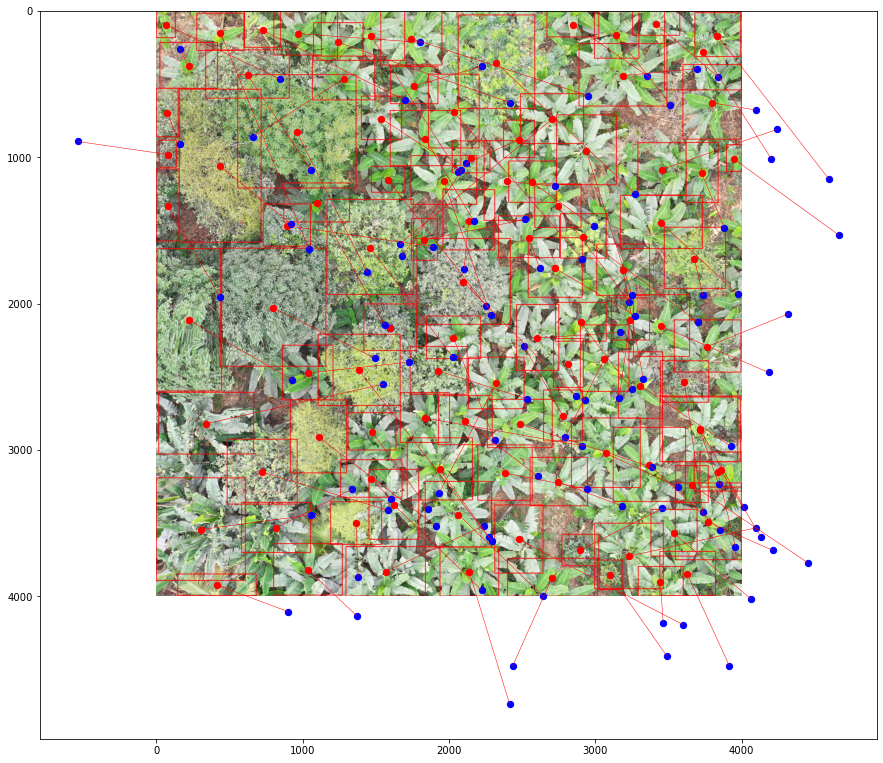

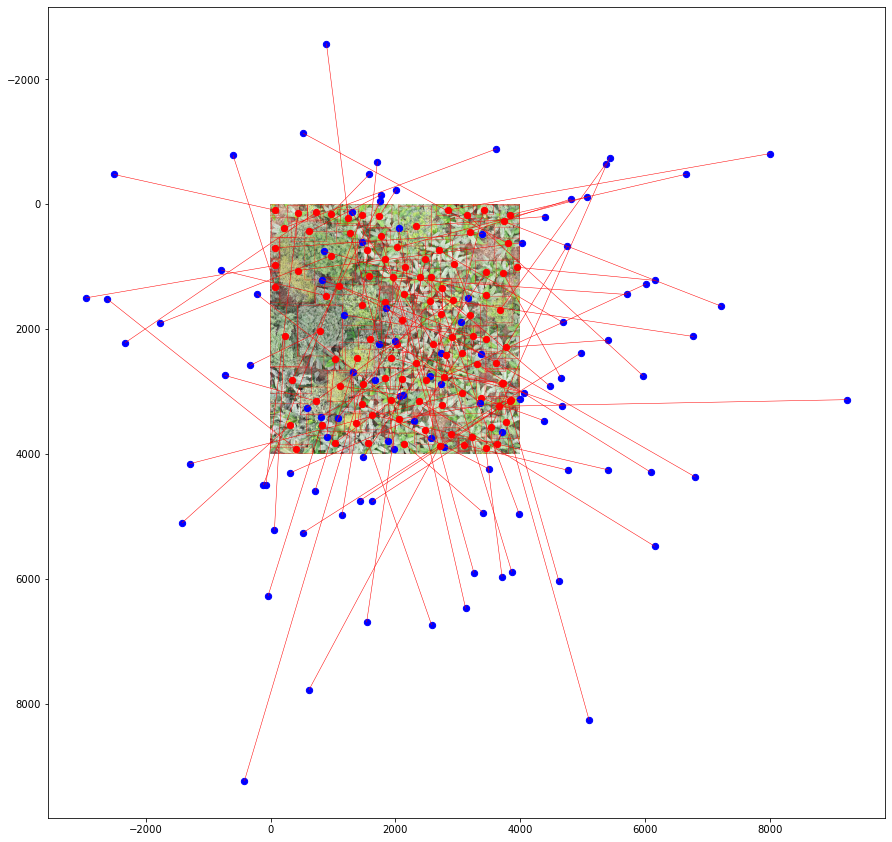

In [101]:
img_path = 'evaluation/test_example.tif'
im = cv2.imread(img_path)
annot = box_to_annotation(boxes[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy())
im = draw_annotations(im, annot, color=(0, 0, 255), label_to_name=None, plot = False, cv2_authorized = False, thickness = 4)


shift = np.array([d_x, d_y])*0.1
X_g = X_g + shift

for k in [0, 0.1, 0.5]:
    sigma = np.array([d_x, d_y])*k
    noise = np.random.normal(0, sigma, (n, 2))
    X_ground = X_g + noise
    X_drone = X_d
    
    
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    for i in range(n):
        plt.scatter(x=X_ground[i][0], y=X_ground[i][1], c='b', s=40)
        plt.scatter(x=X_drone[i][0], y=X_drone[i][1], c='r', s=40)

        plt.plot([X_ground[i][0], X_drone[i][0]], [X_ground[i][1], X_drone[i][1]], color='red', marker=None, linewidth=0.5, markersize=2)
    plt.show()

In [10]:
ratios = [0.05]

In [21]:
def plot_mapping(X_drone, X_ground, idx):

    img_path = 'evaluation/test_example.tif'
    im = cv2.imread(img_path)
    annot = box_to_annotation(boxes[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy())
    im = draw_annotations(im, annot, color=(0, 0, 255), label_to_name=None, plot = False, cv2_authorized = False, thickness = 4)

    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    X_drone_pred = X_drone[idx]
    print(idx)
    n = len(X_ground)
    y_true = range(n)
    res = y_true == idx
    print(res)

    for i in range(n):
        plt.scatter(x=X_ground[i][0], y=X_ground[i][1], c='b', s=40)
        plt.scatter(x=X_drone[i][0], y=X_drone[i][1], c='r', s=40)

        #plt.plot([X_ground[i][0], X_drone[i][0]], [X_ground[i][1], X_drone[i][1]], color='red', marker="o", linewidth=0.5, markersize=2)
        
        if res[i] == True:
            plt.plot([X_ground[i][0], X_drone_pred[i][0]], [X_ground[i][1], X_drone_pred[i][1]], color='green', marker=None, linewidth=1)
        if res[i] == False:
            plt.plot([X_ground[i][0], X_drone_pred[i][0]], [X_ground[i][1], X_drone_pred[i][1]], color='red', marker=None, linewidth=1)

    plt.show()

In [70]:
def evaluation(X_d, X_g, mus_d, mus_g, ratios):
    
    Acc_nn = []
    Acc_ot = []
    Acc_ot_cnn = []
    Acc_gw = []
    
    shift = np.array([d_x, d_y])*0.1
    X_g = X_g + shift

    n = len(X_g)
    for k in range(len(ratios)):
        sigma = np.array([d_x, d_y])*ratios[k]
        noise = np.random.normal(0, sigma, (n, 2))
        X_ground = X_g + noise
        X_drone = X_d
        
        y_true = range(n)

        # Nearest Neighbours
        X_drone_nn = np.hstack((X_drone, np.zeros((n, 1), dtype=np.int32)))
        X_ground_nn = np.hstack((X_ground, np.zeros((n, 1), dtype=np.int32)+1))
        idx = index_nn(X_ground_nn, X_drone_nn)
        Acc_nn.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)

        # OT ground to drone
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        idx = np.argmax(G, axis = 0)
        Acc_ot.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)
        
        """
        # OT greedy
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        cost = -G*10e4
        row_ind, col_ind = linear_sum_assignment(cost)
        Acc_ot_greedy.append(accuracy_score(y_true, col_ind))
        #plot_mapping_inv(X_drone, X_ground, idx)
        
        """
        
        # OT with CNN filtering ground to drone
        G = OT_scores_sinkhorn(X_drone, X_ground, mus_d, mus_g, mu = 1, lambd = 0.01)
        cost = -G
        print(cost)
        print(mus_d)
        print(mus_g)
        row_ind, col_ind = linear_sum_assignment(cost)
        Acc_ot_cnn.append(accuracy_score(y_true, col_ind))
        
        
        # Gromov-Wasserstein
        G = gromov_wasserstein(X_drone, X_ground)
        idx = np.argmax(G, axis = 0)
        Acc_gw.append(accuracy_score(y_true, idx))
        
        
    return(Acc_nn, Acc_ot, Acc_ot_cnn, Acc_gw)

In [71]:
Acc_nn, Acc_ot, Acc_ot_cnn, Acc_gw = evaluation(X_d, X_g, mus_d, mus_g, ratios)

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
105 105
[[-1.89016552e-03 -1.06451049e-79 -5.51479246e-76 ... -1.00232170e-80
  -1.81633125e-79 -5.41076874e-87]
 [-8.62776255e-12 -2.07315407e-03 -8.93346723e-08 ... -1.58727263e-03
  -1.80053647e-03 -1.55743875e-06]
 [-7.79516267e-14 -2.21841486e-09 -4.56743733e-03 ... -9.07220557e-11
  -5.83662667e-10 -1.63296412e-20]
 ...
 [-5.54586243e-14 -1.00854420e-03 -2.25819869e-08 ... -7.83134645e-04
  -3.92500028e-04 -1.24099236e-07]
 [-7.09018357e-14 -1.28415016e-03 -5.18002618e-11 ... -2.19550830e-03
  -1.09270053e-03 -6.69631055e-05]
 [-1.20184430e-18 -4.13867279e-06 -1.29670309e-18 ... -2.83338251e-05
  -5.16584884e-06 -8.72454566e-04]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[[-3.00368899e-03 -9.04949660e-79 -2.31519471e-76 ... -2.41095661e-81
  -4.48459901e-86 -8.41577204e-87]
 [-2.15622487e-13 -1.84997096e-03 -6.74473566e-06 ... -2.01021450e-03
  -9.47127609e-05 -4.60717548e-05]
 [-1.46094851e-13 -1.69474513e-09 -5.66341135e-03 ... -1.69559434e-09
  -1.19385397e-16 -1.53703362e-17]
 ...
 [-2.90296748e-16 -9.68159455e-05 -2.14660447e-06 ... -2.44608938e-03
  -4.85341504e-05 -2.37803466e-05]
 [-1.69752159e-16 -2.78370300e-04 -8.03168148e-09 ... -1.19817814e-03
  -1.49777024e-03 -1.04938044e-03]
 [-1.58070654e-22 -3.50909159e-07 -8.86985068e-16 ... -3.19380796e-06
  -1.85726921e-03 -2.44244431e-03]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-01 9.94944274e-0

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
[[-1.36032798e-03 -4.34799737e-81 -7.10308788e-78 ... -3.11507267e-83
  -7.28532838e-84 -7.05428265e-86]
 [-9.64060241e-12 -1.47383477e-03 -2.13082531e-07 ... -1.25341595e-03
  -3.67173767e-04 -4.07125834e-05]
 [-1.32744163e-11 -3.30554853e-12 -5.37823399e-03 ... -4.30409008e-10
  -7.85123506e-15 -1.50504282e-17]
 ...
 [-6.06264004e-14 -3.85462263e-05 -7.76317885e-08 ... -2.67776350e-03
  -2.37829981e-05 -2.10359677e-06]
 [-1.51795923e-14 -1.05593261e-03 -1.33103448e-10 ... -1.51898181e-03
  -1.37877613e-03 -4.18499079e-04]
 [-4.59827792e-20 -6.26198077e-05 -9.75060357e-18 ... -2.25773934e-05
  -9.03968857e-04 -1.77342468e-03]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-01 9.949

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
[[-1.83225681e-03 -4.85122065e-78 -3.34176833e-75 ... -3.58901366e-82
  -3.54600972e-81 -1.11872140e-89]
 [-1.55221578e-11 -1.72679205e-03 -7.15692464e-06 ... -4.64124998e-04
  -7.73074186e-04 -5.21136023e-08]
 [-1.63034075e-13 -1.56843267e-07 -5.86364306e-03 ... -2.60167427e-12
  -1.49350393e-11 -4.87594816e-22]
 ...
 [-4.46492129e-14 -1.62196189e-04 -4.61752015e-07 ... -8.90957472e-05
  -9.19098151e-05 -5.28869093e-09]
 [-1.76365881e-13 -3.20407562e-04 -1.44595969e-08 ... -1.63801473e-03
  -1.58530282e-03 -5.22187051e-06]
 [-6.03769933e-17 -2.27224170e-06 -4.87523754e-14 ... -1.33046553e-03
  -6.44118939e-04 -1.97126422e-03]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-01 9.949

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
105 105
[[-2.33545398e-04 -2.84074062e-78 -1.02767965e-76 ... -4.18700280e-81
  -4.36312235e-79 -1.41761288e-83]
 [-1.83584526e-10 -1.18974619e-03 -1.28509028e-05 ... -1.09100991e-03
  -1.45589094e-03 -1.40714526e-05]
 [-4.53906629e-14 -4.10210384e-09 -4.74369914e-03 ... -5.30019683e-10
  -1.10094892e-09 -1.05366659e-16]
 ...
 [-3.07910561e-12 -7.74151246e-05 -1.13906882e-05 ... -1.02390940e-03
  -1.61040225e-04 -4.28017850e-07]
 [-1.48045340e-11 -5.50032786e-04 -1.19334936e-07 ... -2.71140732e-03
  -1.27806523e-03 -1.63065396e-04]
 [-1.94209084e-14 -7.37554250e-06 -4.63790263e-13 ... -1.67570729e-04
  -3.95603475e-05 -8.72839261e-04]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
[[-1.98680308e-03 -9.51695839e-80 -2.59782519e-75 ... -2.85899566e-76
  -9.32323437e-82 -3.01055496e-85]
 [-1.29061740e-12 -2.25917434e-03 -2.89231808e-07 ... -1.99753818e-04
  -4.27045115e-04 -3.08639419e-06]
 [-4.29269560e-13 -3.78406115e-11 -3.78745670e-03 ... -3.72332552e-10
  -2.23164830e-14 -6.32121868e-20]
 ...
 [-1.00207642e-14 -2.27785088e-04 -3.17763612e-08 ... -4.70932362e-07
  -2.38823508e-05 -4.77337934e-08]
 [-4.21385693e-15 -2.15339808e-03 -1.65885420e-10 ... -1.04901202e-05
  -1.51861372e-03 -5.33745552e-05]
 [-3.51823856e-20 -8.99502233e-05 -1.69823735e-17 ... -2.02677938e-08
  -8.48228625e-04 -9.07957788e-04]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-01 9.949

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
[[-3.36202178e-03 -6.27668696e-79 -6.15360032e-79 ... -4.08359738e-83
  -1.64860934e-81 -1.98413199e-93]
 [-3.63226591e-13 -1.30439522e-03 -1.64304478e-10 ... -1.75543407e-03
  -1.66108348e-03 -9.20922812e-08]
 [-9.74641566e-11 -5.40349637e-08 -4.12048621e-03 ... -1.21148122e-10
  -4.01441113e-11 -9.92369873e-23]
 ...
 [-1.62997467e-15 -8.22593300e-05 -5.90404642e-11 ... -1.94153671e-03
  -1.70780830e-04 -1.91814700e-07]
 [-8.10736947e-17 -6.48276378e-05 -1.07349418e-14 ... -1.70689484e-03
  -7.73080861e-04 -1.56621846e-05]
 [-2.12174863e-23 -5.08954321e-08 -3.38520040e-23 ... -5.25342457e-05
  -2.28564407e-05 -2.71277363e-03]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-01 9.949

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    8|1.040002e-02|0.000000e+00|0.000000e+00
105 105
105 105
[[-2.54249001e-03 -2.04204369e-81 -3.98308483e-78 ... -5.71762183e-81
  -6.69674886e-80 -3.77576304e-89]
 [-7.63806445e-13 -9.22773744e-04 -1.40984488e-10 ... -1.09774222e-03
  -1.10557829e-03 -1.42379812e-06]
 [-2.91019229e-11 -4.55626443e-12 -3.81009632e-03 ... -1.33966604e-11
  -1.19214159e-10 -2.13700567e-19]
 ...
 [-4.79030992e-15 -5.78992060e-05 -3.01997950e-11 ... -6.14162535e-05
  -3.81398350e-05 -7.34679320e-07]
 [-6.97432003e-16 -1.11398494e-03 -1.50433559e-14 ... -9.86067012e-04
  -4.45766194e-04 -7.21717084e-05]
 [-1.19509926e-21 -1.50630648e-04 -9.83720311e-23 ... -8.47296353e-05
  -1.22685306e-05 -2.13821775e-03]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-0

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
[[-2.64858213e-03 -2.09282570e-78 -1.24279462e-78 ... -2.09541382e-78
  -2.22568308e-83 -5.01273097e-85]
 [-6.06659010e-14 -1.48613129e-03 -2.11055462e-10 ... -2.11865427e-03
  -1.19915245e-05 -8.19047449e-06]
 [-1.23187159e-13 -1.96117612e-09 -5.19628566e-03 ... -2.22056226e-08
  -1.07181498e-16 -5.65969900e-17]
 ...
 [-1.30075230e-16 -9.85537560e-05 -3.98221082e-10 ... -3.67060563e-04
  -3.11294970e-07 -1.17255152e-06]
 [-2.39746009e-16 -1.24184074e-03 -1.82217173e-13 ... -1.52278529e-03
  -1.70754091e-04 -2.60820936e-04]
 [-3.91781885e-21 -3.68824675e-05 -6.18522684e-21 ... -2.11002992e-05
  -1.13636686e-03 -2.88126175e-03]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-01 9.949

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
[[-1.44201286e-03 -5.02489240e-83 -1.36902883e-77 ... -1.02100780e-76
  -6.65294153e-77 -9.52620273e-83]
 [-5.68681077e-13 -3.55399536e-05 -1.69459053e-03 ... -1.99638747e-03
  -9.29094514e-04 -5.58154095e-05]
 [-1.43000311e-12 -8.62683669e-13 -1.75556878e-04 ... -3.85877470e-04
  -8.30250812e-07 -2.74882998e-12]
 ...
 [-5.30877333e-15 -1.82077265e-05 -2.67813042e-03 ... -1.50143092e-03
  -7.85951369e-05 -3.37114692e-05]
 [-1.04730204e-14 -5.56969263e-04 -6.76605086e-04 ... -4.88664665e-04
  -3.83640481e-04 -7.74485332e-04]
 [-1.38450309e-18 -1.11288820e-03 -1.28458918e-06 ... -5.84404346e-07
  -3.55455583e-06 -1.14971632e-03]]
[6.13480806e-04 9.99899983e-01 9.99899983e-01 9.99999975e-05
 3.12793016e-01 9.99873042e-01 2.80178189e-02 7.80690551e-01
 9.93356824e-01 5.84188104e-03 9.99899983e-01 9.99899983e-01
 7.16650844e-01 9.35194492e-02 1.33338183e-01 9.99999975e-05
 1.63018703e-03 2.42292881e-04 9.99899983e-01 3.01212847e-01
 8.56070518e-01 3.16559970e-01 1.61059529e-01 9.949

In [26]:
Acc_nn, Acc_ot

([0.11428571428571428], [0.5333333333333333])

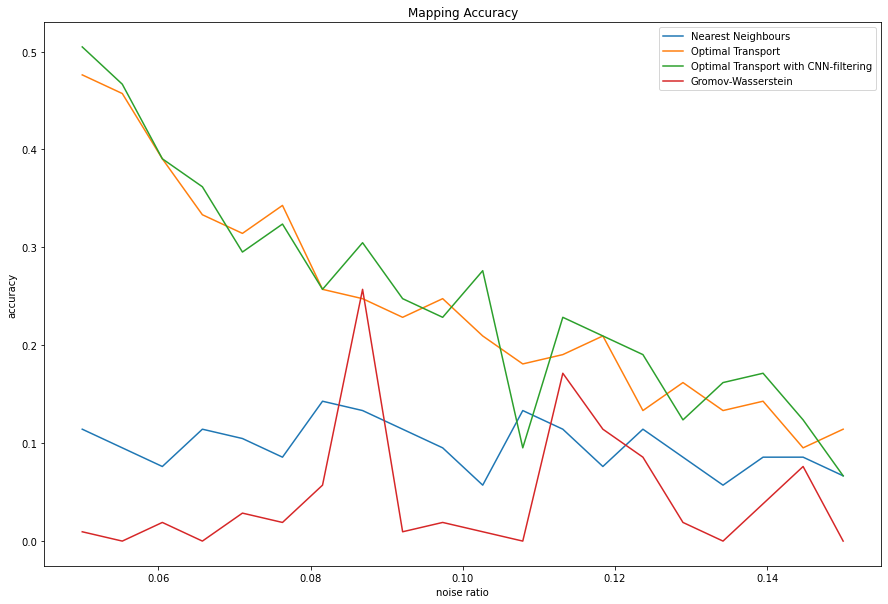

In [72]:
plt.figure(figsize=(15,10))
plt.title('Mapping Accuracy')
plt.xlabel('noise ratio')
plt.ylabel('accuracy')


plt.plot(ratios, Acc_nn, label = 'Nearest Neighbours')
plt.plot(ratios, Acc_ot, label = 'Optimal Transport')
plt.plot(ratios, Acc_ot_cnn, label = 'Optimal Transport with CNN-filtering')
plt.plot(ratios, Acc_gw, label = 'Gromov-Wasserstein')
plt.legend()